In [1]:
# Calcul de la divergence de Jensen-Shannon entre deux distributions de probabilités
import numpy as np

# Définition des distributions
P = np.array([0.9, 0.1])
Q = np.array([0.5, 0.5])
M = (P + Q) / 2  # Moyenne des distributions
print(f'P = {P}')
print(f'Q = {Q}')
print(f'M = {M}')
# Fonction pour calculer KL(P || Q)
def kl_divergence(P, Q):
    return np.sum(P * np.log(P / Q))

# Calcul des divergences KL
kl_P_M = kl_divergence(P, M)
kl_Q_M = kl_divergence(Q, M)

# Calcul de la divergence de Jensen-Shannon
js_divergence = 0.5 * (kl_P_M + kl_Q_M)

kl_P_M, kl_Q_M, js_divergence

P = [0.9 0.1]
Q = [0.5 0.5]
M = [0.7 0.3]


(0.1163217565860046, 0.08717669357238891, 0.10174922507919676)

In [2]:
# Création d'un GAN

# Importation des modules
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed) # Pour reproductibilité

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count()) # Nombre de GPU disponibles
print(f'Nombre de GPU disponibles : {AVAIL_GPUS}')
NUM_WORKERS=int(os.cpu_count() / 2) # Nombre de coeurs disponibles
print(f'Nombre de coeurs disponibles : {NUM_WORKERS}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Utilisation du device : {device}')

Nombre de GPU disponibles : 1
Nombre de coeurs disponibles : 12
Utilisation du device : cuda


In [3]:
# Création du dataset MNIST
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        # On définit les paramètres du dataset
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        # On définit la transformation à appliquer aux images
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(), # Conversion en tenseur
                transforms.Normalize((0.1307,), (0.3081,)), # Normalisation des données avec la moyenne et l'écart-type
            ]
        )
    # On télécharge les données et on les prépare
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True) # Téléchargement des données d'entrainement
        MNIST(self.data_dir, train=False, download=True) # Pas d'entrainement sur les données de test

    def setup(self, stage=None):
        # split train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
# Le dicriminateur qui est un simple classifieur binaire
# Définir la précision de multiplication de matrices pour utiliser les Tensor Cores
torch.set_float32_matmul_precision('high')  
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [5]:
# Generateur qui génere les Fake Data: output de la même dimension que les vraies data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [6]:
# Mettre les réseaux dans une classe
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters() # Sauvegarde des hyperparamètres pour qu'ils soient accessibles dans le modèle
        self.generator = Generator(latent_dim=self.hparams.latent_dim) # Initialisation du générateur avec la dimension latente sauvée juste avant
        self.discriminator = Discriminator() # Initialisation du discriminateur
        self.automatic_optimization = False  # Désactiver l'optimisation automatique pour pouvoir utiliser plusieurs optimiseurs
        # Random noise
        self.validation_z = torch.randn(8, self.hparams.latent_dim, device=self.device)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        opt_g, opt_d = self.optimizers()  # Récupération des optimiseurs
        real_imgs, _ = batch

        # Sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim, device=self.device)
        z = z.type_as(real_imgs)

        # -----------------------------
        # 1. Train Generator (maximize log(D(G(z))))
        # -----------------------------
        opt_g.zero_grad()  # Reset des gradients
        gen_imgs = self.generator(z)
        y_hat = self.discriminator(gen_imgs)
        y = torch.ones(real_imgs.size(0), 1, device=self.device)  # Labels "réels"
        g_loss = self.adversarial_loss(y_hat, y)
        
        self.manual_backward(g_loss)  # Rétropropagation manuelle
        opt_g.step()  # Mise à jour des poids

        self.log("g_loss", g_loss, prog_bar=True)

        # -----------------------------
        # 2. Train Discriminator (maximize log(D(x)) + log(1 - D(G(z))))
        # -----------------------------
        opt_d.zero_grad()  # Reset des gradients

        # Vraies images
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1, device=self.device)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        # Fausses images
        y_hat_fake = self.discriminator(gen_imgs.detach())  # .detach() pour ne pas backprop sur G
        y_fake = torch.zeros(real_imgs.size(0), 1, device=self.device)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2

        self.manual_backward(d_loss)  # Rétropropagation manuelle
        opt_d.step()  # Mise à jour des poids

        self.log("d_loss", d_loss, prog_bar=True)

        return g_loss + d_loss  # Retourner une perte combinée
        
    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_images(self):
        z = self.validation_z.type_as(self.generator.lin1.weight) # On utilise les données générées pour le plot
        sample_imgs = self(z).cpu() # génération des images et passage en CPU

        # Plot et print après chaque epoch
        print('epoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(len(sample_imgs)):
            plt.subplot(2, 4, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0,:,:], cmap='gray', interpolation='none')
            plt.title(f'Images générées')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_epoch_end(self):
        self.plot_images()


In [7]:
dm = MNISTDataModule()
model = GAN()
print(model)

GAN(
  (generator): Generator(
    (lin1): Linear(in_features=100, out_features=3136, bias=True)
    (ct1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (ct2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (conv): Conv2d(16, 1, kernel_size=(7, 7), stride=(1, 1))
  )
  (discriminator): Discriminator(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=1, bias=True)
  )
)


epoch  0


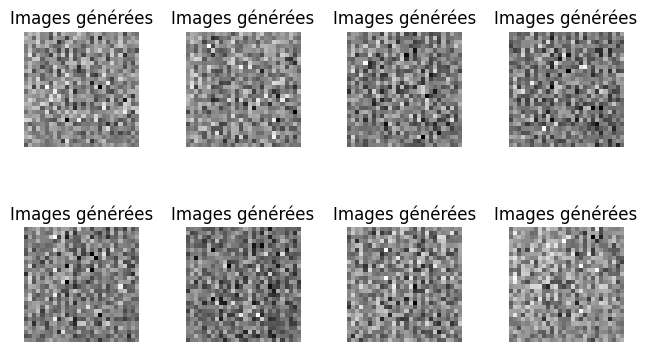

In [8]:
model.plot_images()

In [9]:
trainer = pl.Trainer(max_epochs=1000, devices=AVAIL_GPUS, accelerator='gpu')
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\mathi\anaconda3\envs\TorchGPU\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 430/430 [00:03<00:00, 113.76it/s, v_num=6, g_loss=0.870, d_loss=0.614]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 430/430 [00:03<00:00, 113.34it/s, v_num=6, g_loss=0.870, d_loss=0.614]


epoch  1000


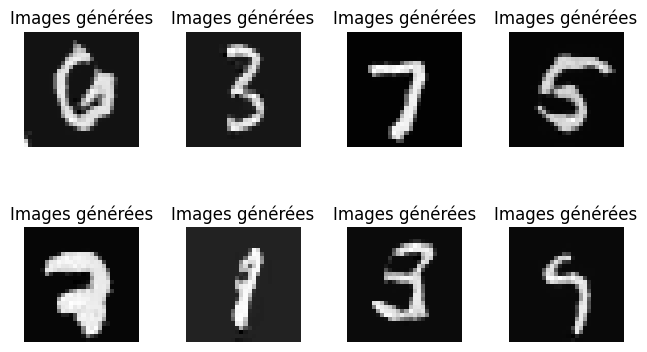

In [10]:
# Image générée après entrainement
model.plot_images()